# Atlas notebooks

***

> This notebook reproduces and extends parts of the figures and products of the AR6-WGI Atlas. It is part of a notebook collection available at https://github.com/IPCC-WG1/Atlas for reproducibility and reusability purposes. This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Bias adjustment of model temperatures for the calculation of extreme indices
29/6/2021

**A. Casanueva** ([Santander Meteorology Group](http://meteo.unican.es). Dept. Applied Mathematics and Compute Science, University of Cantabria, Santander, Spain)

Bias adjustment is used in the IPCC interactive Atlas for the calculation of absolute threshold-based indices, namely the number of days with maximum temperature above 35ºC (TX35) and above 40ºC (TX40), and the number of frost days (minimum temperature below 0ºC). More details about bias adjustment can be found in the Atlas chapter from the IPCC-AR6 (Cross-Chapter Box 10.2: "Issues in bias adjustment") and in [Casanueva et al. 2020](https://doi.org/10.1002/asl.978).

Among the wide variety of methods typically used by the climate community for bias adjustment, this notebook focuses on ISIMIP3 ([Lange 2019](https://doi.org/10.5194/gmd-12-3055-2019)), a parametric quantile mapping alternative which has been designed to robustly adjust biases in all percentiles of a distribution whilst preserving their trends. In particular, we use ISIMIP3 in this example to bias-adjust temperature from the r12i1p1 run of the EC-EARTH global climate model, included in the fifth phase of the Coupled Model Intercomparison Project (CMIP5), over the Iberian Peninsula using as reference the W5E5 observational dataset ([Cucchi et al. 2020](https://doi.org/10.5194/essd-12-2097-202)). We focus on the boreal summer season (June-July-August) for the calculation of bias-adjusted TX35.

### Loading packages
This notebook is based on the R programming language and requires the following [climate4R](https://github.com/SantanderMetGroup/climate4R) packages:

 * `loadeR` to load climate model and observational datasets ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `climate4R.UDG` to access harmonized climate data via the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/).
 * `transformeR` to manipulate climate data ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `downscaleR` to adjust systematic model biases ([Bedia et al. 2020](https://doi.org/10.5194/gmd-13-1711-2020)).
 * `climate4R.indices` to compute climate indices ([Iturbide et al. 2019](https://doi.org/10.1016/j.envsoft.2018.09.009)).
 * `visualizeR` to produce graphical representations of the results ([Frías et al. 2018](https://doi.org/10.1016/j.envsoft.2017.09.008)).
 
Along with:

 * `rgdal` to work with spatial data ([Bivand et al., 2018](https://CRAN.R-project.org/package=rgdal)).

In [ ]:
library(loadeR) 
library(climate4R.UDG) 
library(transformeR)
library(downscaleR)
library(climate4R.indices)
library(visualizeR)
library(rgdal)

### Defining the parameters of the experiment
We start by setting the general parameters that define the experiment to perform: spatial extent (Iberian Peninsula), season (June-July-August), baseline/historical period (1986-2005) and future period/emission scenario (2041-2060, RCP8.5) of interest. We set likewise the codes which identify the desired datasets in the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/) , here W5E5 and EC-EARTH (historical and RCP8.5). Check other available, harmonized datasets with `?UDG.datasets`.

In [ ]:
lons <- c(-9.25, 3.5)  # Iberian Peninsula
lats <- c(36, 44)   # Iberian Peninsula

season <- 6:8  # June-July-August
years.hist <- 1986:2005
years.rcp <- 2041:2060

dataset.obs <- "W5E5" 
dataset.hist <- "CMIP5_EC-EARTH_r12i1p1_historical"
dataset.rcp <- "CMIP5_EC-EARTH_r12i1p1_rcp85"

### Loading datasets 
Next, we will see two alternative ways to load in memory the datasets that are needed to run this experiment. On the one hand, both W5E5 and EC-EARTH can be accessed from the [Santander Meteorology Group UDG-TAP](http://meteo.unican.es/udg-tap/), a THREDDS-based service that provides access to a wide catalogue of popular climate datasets. On the other hand, for the sake of time, these data have been also stored locally as `NetCDF` files and can be directly loaded from the `auxiliary-material` folder. In both cases, the datasets can be easily accessed via the `loadGridData` function.

####  Online from the User Data Gateway - Thredds Access Portal (UDG-TAP)

> This section takes long to execute due to intensive remote data loading. See the next section ([From local files](#From-local-files)) to load these data from a local copy available in the repository and continue with the notebook operations.


Previously defined parameters are used to load daily observed (W5E5) and simulated (EC-EARTH) temperatures from the UDG-TAP. For EC-EARTH, both historical and future (i.e. RCP8.5) simulations are needed. It is important to note that not only mean, but also minimum and maximum temperatures are required by the ISIMIP3 method to adjust maximum and minimum temperature, which are obtained from the correction of the amplitude and skewness of the diurnal temperature cycle.

```R

load.data <- function (dset, years, var) loadGridData(dataset = dset, var = var,
                                                 years = years,
                                                 latLim = lats, lonLim = lons,
                                                 season = season) 
# Loading mean temperature
y.tas <- load.data(dataset.obs, years.hist, "tas")
x.tas <- load.data(dataset.hist, years.hist, "tas")
newdata.tas <- load.data(dataset.rcp, years.rcp, "tas")

# Loading minimum temperature
y.tasmin <- load.data(dataset.obs, years.hist, "tasmin")
x.tasmin <- load.data(dataset.hist, years.hist, "tasmin")
newdata.tasmin <- load.data(dataset.rcp, years.rcp, "tasmin")

# Loading maximum temperature
y.tasmax <- load.data(dataset.obs, years.hist, "tasmax")
x.tasmax <- load.data(dataset.hist, years.hist, "tasmax")
newdata.tasmax <- load.data(dataset.rcp, years.rcp, "tasmax")
```

Due to the spatial mismatch between model and observations, we upscale W5E5 from its original resolution (0.5º) to a 1º regular grid similar to that of EC-EARTH (1.125º). See [Casanueva et al. 2020](https://doi.org/10.1002/asl.978) for a discussion on this procedure. 

```R
upscale <- function(grid) redim(upscaleGrid(grid, times = 2, aggr.fun = list(FUN = "mean", na.rm = TRUE)), 
                                drop = TRUE)
y.tas <- upscale(y.tas)
y.tasmax <- upscale(y.tasmax)
y.tasmin <- upscale(y.tasmin)
```

####  From local files

Alternatively, these data (both W5E5 and EC-EARTH, for the Iberian Peninsula and the selected time slices) can be directly loaded from the `auxiliary-material` folder by using the `loadGridData` function (skip this section if you have sucessfully loaded your data from the UDG-TAP). 

In [ ]:
file.obs <- "auxiliary-material/W5E5_IP_tas-tasmin-tasmax_1986-2005_JJA.nc"
file.hist <- "auxiliary-material/CMIP5_EC-EARTH_r12i1p1_historical_IP_tas-tasmin-tasmax_1986-2005_JJA.nc"
file.rcp <- "auxiliary-material/CMIP5_EC-EARTH_r12i1p1_rcp85_IP_tas-tasmin-tasmax_2041-2060_JJA.nc"

# Loading mean temperature
y.tas <- loadGridData(file.obs, var = "tas")
x.tas <- loadGridData(file.hist, var = "tas")
newdata.tas <- loadGridData(file.rcp, var = "tas")

# Loading minimum temperature
y.tasmin <- loadGridData(file.obs, var = "tasmin")
x.tasmin <- loadGridData(file.hist, var = "tasmin")
newdata.tasmin <- loadGridData(file.rcp, var = "tasmin")

# Loading maximum temperature
y.tasmax <- loadGridData(file.obs, var = "tasmax")
x.tasmax <- loadGridData(file.hist, var = "tasmax")
newdata.tasmax <- loadGridData(file.rcp, var = "tasmax")

### Model biases

We continue by exploring EC-EARTH systematic biases compared to W5E5. For this purpose we interpolate the historical EC-EARTH simulations (recall, at 1.125º) to the W5E5's grid (at 1º) with `interpGrid`.

In [ ]:
hist.tas <- interpGrid(x.tas, new.coordinates = getGrid(y.tas), method = "nearest")
hist.tasmin <- interpGrid(x.tasmin, new.coordinates = getGrid(y.tasmin), method = "nearest")
hist.tasmax <- interpGrid(x.tasmax, new.coordinates = getGrid(y.tasmax), method = "nearest")

Please note that nearest neighbour interpolation is internally performed within the `biasCorrection` function (which will be used later) when observations and model grids do not match. Nevertheless, we explicitly do it here for biases calculation. Mean bias of daily mean, maximum and minimum temperature during the historical period are computed with `gridArithmetics`. 

In [ ]:
bias.tas <- gridArithmetics(climatology(hist.tas), climatology(y.tas), operator = "-")
bias.tasmax <- gridArithmetics(climatology(hist.tasmax), climatology(y.tasmax), operator = "-")
bias.tasmin <- gridArithmetics(climatology(hist.tasmin), climatology(y.tasmin), operator = "-")

The results are plotted with the `spatialPlot` function from the `visualizeR` package.

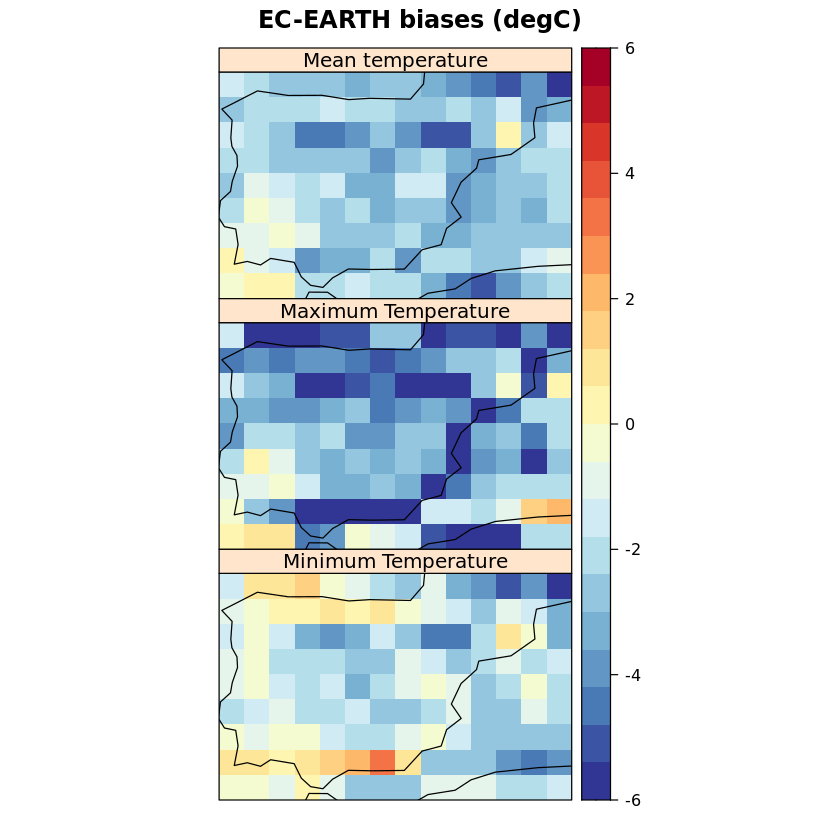

In [18]:
spatialPlot(suppressMessages(makeMultiGrid(bias.tas, bias.tasmax, bias.tasmin, skip.temporal.check = TRUE)), 
            backdrop.theme = "coastline", 
            names.attr = c("Mean temperature", "Maximum Temperature", "Minimum Temperature"),
            main = "EC-EARTH biases (degC)", layout = c(1, 3), as.table = TRUE, 
            set.min = -6, set.max = 6, at = seq(-6, 6, 12/20), rev.colors = TRUE)

Similarly, we can also visualize the EC-EARTH bias for TX35 (number of days per year with maximum temperature above 35º) during the historical period. This index can be easily computed with the `indexGrid` function:

In [ ]:
# Observed TX35, year by year
index.obs <- redim(indexGrid(tx = y.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), 
                   drop = TRUE)
# Simulated TX35, year by year
index.raw <- redim(indexGrid(tx = hist.tasmax, index.code = "TXth", th = 35, time.resolution = "year"), 
                   drop = TRUE)

tx35.obs <- climatology(index.obs)  # Mean value
tx35.raw <- climatology(index.raw)  # Mean value
bias.tx35 <- gridArithmetics(tx35.raw, tx35.obs, operator = "-")  # Bias

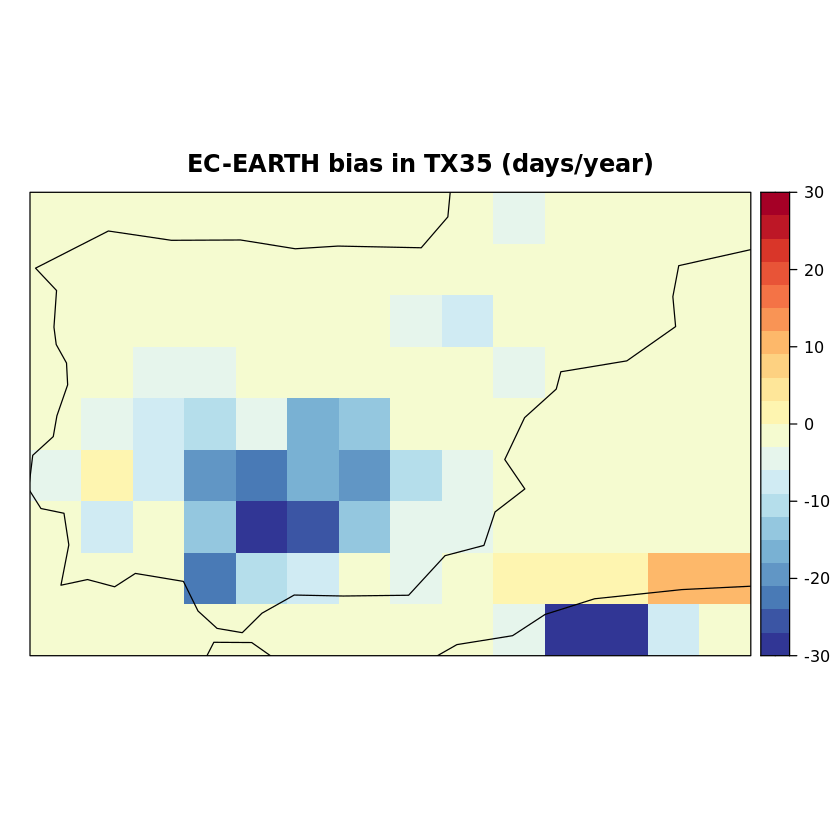

In [19]:
spatialPlot(bias.tx35, backdrop.theme = "coastline", main = "EC-EARTH bias in TX35 (days/year)", 
            set.min = -30, set.max = 30, 
            at = seq(-30, 30, 60/20),
            rev.colors = TRUE)

### Bias adjustment
Three individual adjustments need to be done to get bias-adjusted daily minimum and maximum temperatures with the ISIMIP3 method:

1. Bias adjustment of mean temperature
2. Bias adjustment of temperature range
3. Bias adjustment of temperature skewness

In this example, the three steps are next undertaken to correct both historical and future model simulations.

We start by calculating the temperature range and skewness for the observations and (historical and future) simulations using the `gridArithmetics` function:

In [ ]:
# Range
y.range <- gridArithmetics(y.tasmax, y.tasmin, operator = "-")
x.range <- gridArithmetics(x.tasmax, x.tasmin, operator = "-")
newdata.range <- gridArithmetics(newdata.tasmax, newdata.tasmin, operator = "-")

# Skewness
y.skew <- gridArithmetics(gridArithmetics(y.tas, y.tasmin, operator = "-"), y.range, operator = "/")
x.skew <- gridArithmetics(gridArithmetics(x.tas,x.tasmin, operator = "-"), x.range, operator = "/")
newdata.skew <- gridArithmetics(gridArithmetics(newdata.tas, newdata.tasmin, operator = "-"), 
                                newdata.range, operator = "/")

Next, the `biasCorrection` function is used to perform the three steps mentioned above, by indicating the ISIMIP3 method and related arguments as inputs. Other (methodologically simpler) methods are also available in `biasCorrection`; the reader is referred to the function documentation for more details.

1.Bias adjustment of daily mean temperature:

In [ ]:
# List of arguments that have to be passed to the "biasCorrection" function when using the ISIMIP3 method
isimip3.args = list(lower_bound = NULL,lower_threshold = NULL, upper_bound = NULL, 
                    upper_threshold = NULL,  randomization_seed =  NULL, 
                    detrend = array(data = TRUE, dim = 1), rotation_matrices = NULL, 
                    n_quantiles = 50, distribution = "normal", 
                    trend_preservation = array(data = "additive", dim = 1), 
                    adjust_p_values = array(data = FALSE, dim = 1), if_all_invalid_use = NULL, 
                    invalid_value_warnings = FALSE)

# Adjusting historical simulations
bc.tas.hist <- biasCorrection(y = y.tas, x = x.tas, newdata = x.tas, "precipitation" = FALSE, 
                         method = "isimip3", isimip3.args = isimip3.args)
# Adjusting future simulations
bc.tas <- biasCorrection(y = y.tas, x = x.tas, newdata = newdata.tas, "precipitation" = FALSE, 
                         method = "isimip3", isimip3.args = isimip3.args)

2.Bias ajustment of the daily temperature range:

In [ ]:
# List of arguments that have to be passed to the "biasCorrection" function when using the ISIMIP3 method
isimip3.range.args = list(lower_bound = 0, lower_threshold = 0.01, upper_bound = NULL, 
                            upper_threshold = NULL, randomization_seed = NULL, 
                            detrend = array(data = FALSE, dim = 1), rotation_matrices =  NULL, 
                            n_quantiles = 50, distribution = "rice", 
                            trend_preservation = array(data = "mixed", dim = 1),
                            adjust_p_values = array(data = FALSE, dim = 1), if_all_invalid_use = NULL, 
                            invalid_value_warnings = FALSE)

# Adjusting historical simulations
bc.range.hist <- biasCorrection(y = y.range, x = x.range, newdata = x.range, "precipitation" = FALSE, 
                                method = "isimip3", isimip3.args = isimip3.range.args)
# Adjusting future simulations                           
bc.range <- biasCorrection(y = y.range, x = x.range, newdata = newdata.range, "precipitation" = FALSE, 
                           method = "isimip3", isimip3.args = isimip3.range.args)

3.Bias adjustment of the daily temperature skewness:

In [ ]:
# List of arguments that have to be passed to the "biasCorrection" function when using the ISIMIP3 method
isimip3.skew.args  =  list(lower_bound =  c(0), lower_threshold =  c(0.0001), upper_bound =  c(1), 
                           upper_threshold =  c(0.9999), randomization_seed =  NULL,
                           detrend =  array(data  =  FALSE, dim = 1), rotation_matrices =  c(NULL), 
                           n_quantiles = 50, distribution =  c("beta"), 
                           trend_preservation = array(data = "bounded", dim = 1), 
                           adjust_p_values = array(data  =  FALSE, dim = 1), if_all_invalid_use  =  c(NULL),
                           invalid_value_warnings  =  FALSE)

# Adjusting historical simulations
bc.skew.hist <- biasCorrection(y = y.skew, x = x.skew, newdata = x.skew, "precipitation" = FALSE, 
                          method = "isimip3", isimip3.args = isimip3.skew.args)
# Adjusting future simulations
bc.skew <- biasCorrection(y = y.skew, x = x.skew, newdata = newdata.skew, "precipitation" = FALSE, 
                          method = "isimip3", isimip3.args = isimip3.skew.args)

Once these three steps are completed, the bias-adjusted daily maximum and minimum temperature can be obtained as follows:

In [ ]:
# Bias-adjusted historical temperatures
bc.tasmin.hist <- gridArithmetics(bc.tas.hist, gridArithmetics(bc.range.hist, bc.skew.hist, operator = "*"), 
                                  operator = "-")
bc.tasmax.hist <- gridArithmetics(bc.tasmin.hist, bc.range.hist, operator = "+")

# Bias-adjusted future temperatures
bc.tasmin <- gridArithmetics(bc.tas, gridArithmetics(bc.range, bc.skew, operator = "*"), 
                             operator = "-")
bc.tasmax <- gridArithmetics(bc.tasmin, bc.range, operator = "+")

### Calculation of extreme temperature indices
Finally, we use the `indexGrid` function to compute historical and future TX35 based on the bias-adjusted daily maximum temperature which has been obtained from the application of the ISIMIP3 method. 

In [ ]:
# Bias-adjusted TX35 for the historical period, year by year
index.hist <- redim(indexGrid(tx = bc.tasmax.hist, index.code = "TXth", th = 35, 
                              time.resolution = "year"), drop = TRUE)
tx35.hist <- climatology(index.hist)  # Mean value (number of days/year)

# Bias-adjusted TX35 for the future period of interest, year by year
index.rcp <- redim(indexGrid(tx = bc.tasmax, index.code = "TXth", th = 35, 
                             time.resolution = "year"), drop = TRUE)
tx35.rcp <- climatology(index.rcp) # Mean value (number of days/year)

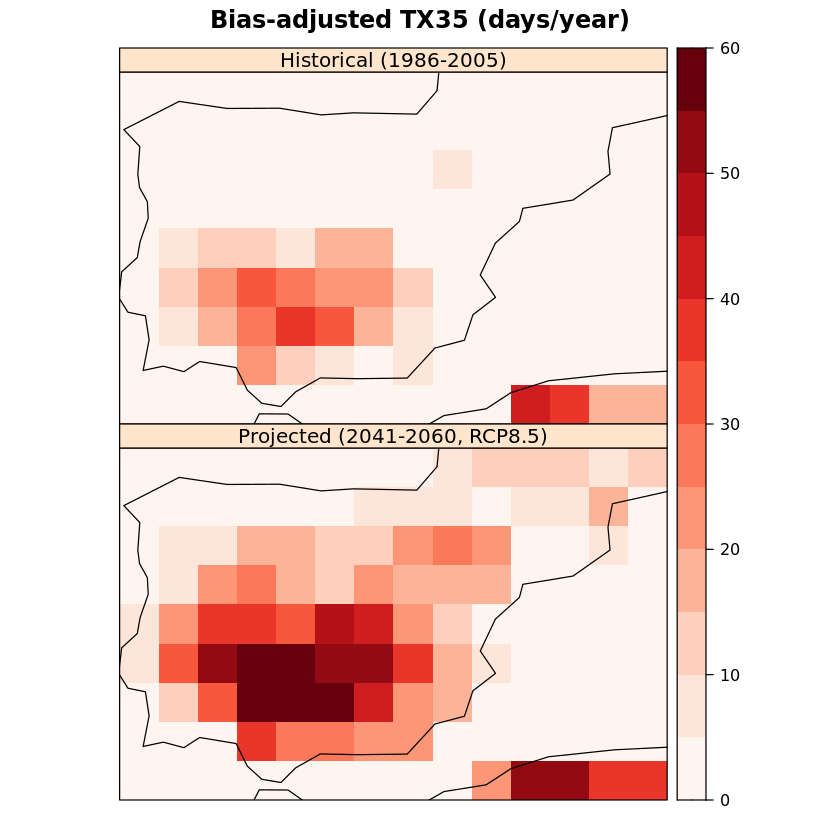

In [20]:
spatialPlot(makeMultiGrid(tx35.hist, tx35.rcp, skip.temporal.check = TRUE), backdrop.theme = "coastline", 
            color.them = "Reds", names.attr = c("Historical (1986-2005)","Projected (2041-2060, RCP8.5)"),
            main = "Bias-adjusted TX35 (days/year)", as.table = TRUE, set.min = 0, set.max = 60, at = seq(0,60,5))

### Session info

In [21]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /srv/conda/envs/notebook/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] rgdal_1.5-16            sp_1.4-5                visualizeR_1.6.1       
 [4] climate4R.indices_0.2.0 downscaleR_3.3.3        transformeR_2.1.2      
 [7] loadeR_1.7.1            climate4R.UDG_0.2.3     loadeR.java_1.1.1      
[10] rJava_1.0-4            

loaded via a names

### References

* Bedia, J., Baño-Medina, J., Legasa, M.N., Iturbide, M., Manzanas, R., Herrera, S., Casanueva, A., San-Martín, D., Cofiño, A.S. and Gutiérrez, J.M. (2020) Statistical downscaling with the downscaleR package (v3.1.0): contribution to the VALUE intercomparison experiment. Geoscientific Model Developmen, 13, 1711–1735.
https://doi.org/10.5194/gmd-13-1711-2020.
* Bivand R.S., Keitt T., Rowlingson B. (2018). rgdal: Bindings for the ‘Geospatial’ Data Abstraction Library. R package version 1.3-6. https://CRAN.R-project.org/package=rgdal
*  Casanueva, A, Herrera, S, Iturbide, M, et al. (2020) Testing bias adjustment methods for regional climate change applications under observational uncertainty and resolution mismatch. Atmos Sci Lett. 21: 21:e978. https://doi.org/10.1002/asl.978
* Cucchi, M.,Weedon, G. P., Amici, A., Bellouin, N., Lange, S., Schmied, H. M., Hersbach, H. and Buontempo, C. (2020) WFDE5: bias-adjusted ERA5 reanalysis data for impact studies. Earth System Science Data, 12, 2097–2120,  https://doi.org/10.5194/essd-12-2097-2020.
* Frías, M.D., Iturbide, M., Manzanas, R., Bedia, J., Fernández, J., Herrera, S., Cofiño, A.S., Gutiérrez, J.M. (2018). An R package to visualize and communicate uncertainty in seasonal climate prediction. Environ. Model. Software 99, 101–110. https://doi.org/10.1016/j.envsoft.2017.09.008.
* Iturbide, M., Bedia, J., Herrera, S., Baño-Medina, J., Fernández, J., Frías, M. D., Manzanas, R., San-Martín, D., Cimadevilla, E., Cofiño, A. S., and Gutiérrez, J. M. (2019) The R-based climate4R open framework for reproducible climate data access and post-processing, Environ. Modell. Softw., 111, 42–54,
https://doi.org/10.1016/j.envsoft.2018.09.009.
* Lange, S. (2019) Trend-preserving bias adjustment and statistical downscaling with ISIMIP3BASD (v1.0). Geoscientific Model Development, 12, 3055–3070. https://doi.org/10.5194/gmd-12-3055-2019.
